## Driver drowsiness detection is a car safety technology which helps prevent accidents caused by the driver getting drowsy. Various studies have suggested that around 20% of all road accidents are fatigue-related, up to 50% on certain roads

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping 

# Set constant

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNELS = 3

# load dataset

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/nazil/Downloads/Data/train',
    seed = 1000,
    shuffle = True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 1452 files belonging to 2 classes.


In [7]:
class_names=dataset.class_names
class_names

['Closed', 'Open']

In [8]:
dataset.element_spec

(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

## Visualize some random images

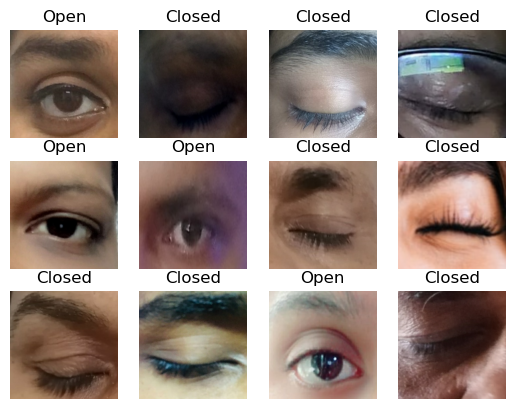

In [9]:
for image_batch, labels_name in dataset.take(2):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_name[i]])
        plt.axis('off')

plt.show()

# Split the dataset

In [10]:
def get_split_data(ds, train_split=0.8, test_splt=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_splt + val_split ) == 1
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_split_data(dataset)

In [12]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

36
6
4


# Cache,Shuffle And Prefetch data

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing And Normalization

In [14]:
resize_and_rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

# Data Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

# Apply Data Augmentation to the Train Dataset

In [16]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
model = models.Sequential([
    # Clarify or implement the `resize_and_rescale` layer here
    resize_and_rescale,  # Replace with appropriate implementation

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
# Compile the model with updated optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),  # Specify learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

# Fit the model

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE, 
    validation_data=val_ds,
    epochs=40 )

Epoch 1/40


36/36 [==============================] - 47s 1s/step - loss: 0.4356 - accuracy: 0.7778 - val_loss: 0.4510 - val_accuracy: 0.7578
Epoch 2/40
36/36 [==============================] - 42s 1s/step - loss: 0.2477 - accuracy: 0.8924 - val_loss: 0.2361 - val_accuracy: 0.9141
Epoch 3/40
36/36 [==============================] - 42s 1s/step - loss: 0.2175 - accuracy: 0.9219 - val_loss: 0.1843 - val_accuracy: 0.9297
Epoch 4/40
36/36 [==============================] - 42s 1s/step - loss: 0.2072 - accuracy: 0.9193 - val_loss: 0.9342 - val_accuracy: 0.6719
Epoch 5/40
36/36 [==============================] - 43s 1s/step - loss: 0.1923 - accuracy: 0.9210 - val_loss: 0.8514 - val_accuracy: 0.7266
Epoch 6/40
36/36 [==============================] - 42s 1s/step - loss: 0.2104 - accuracy: 0.9149 - val_loss: 0.1298 - val_accuracy: 0.9453
Epoch 7/40
36/36 [==============================] - 42s 1s/step - loss: 0.1993 - accuracy: 0.9201 - val_loss: 0.1554 - val_accuracy: 0.9375
Epoch 8/40
36/36 [

Text(0.5, 1.0, 'Training and Validation loss')

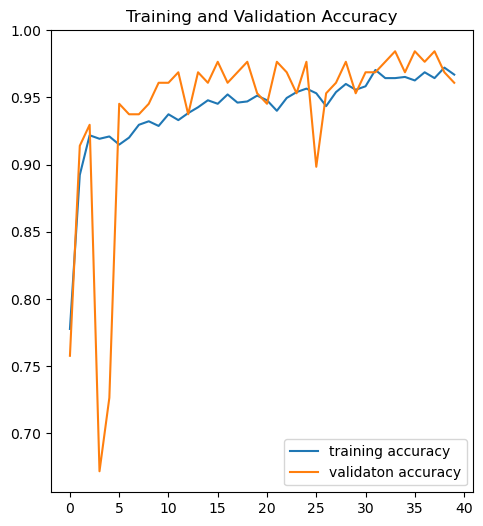

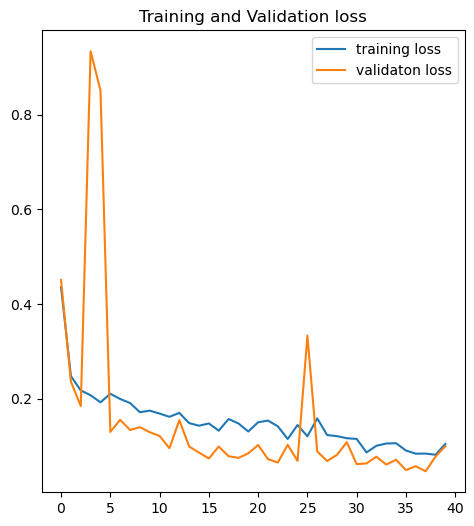

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss =history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = len(acc) 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'training accuracy')
plt.plot(range(EPOCHS), val_acc, label='validaton accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label='validaton loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss') 

# Prection System

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidance = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidance

1/1 [==============================] - 0s 28ms/step


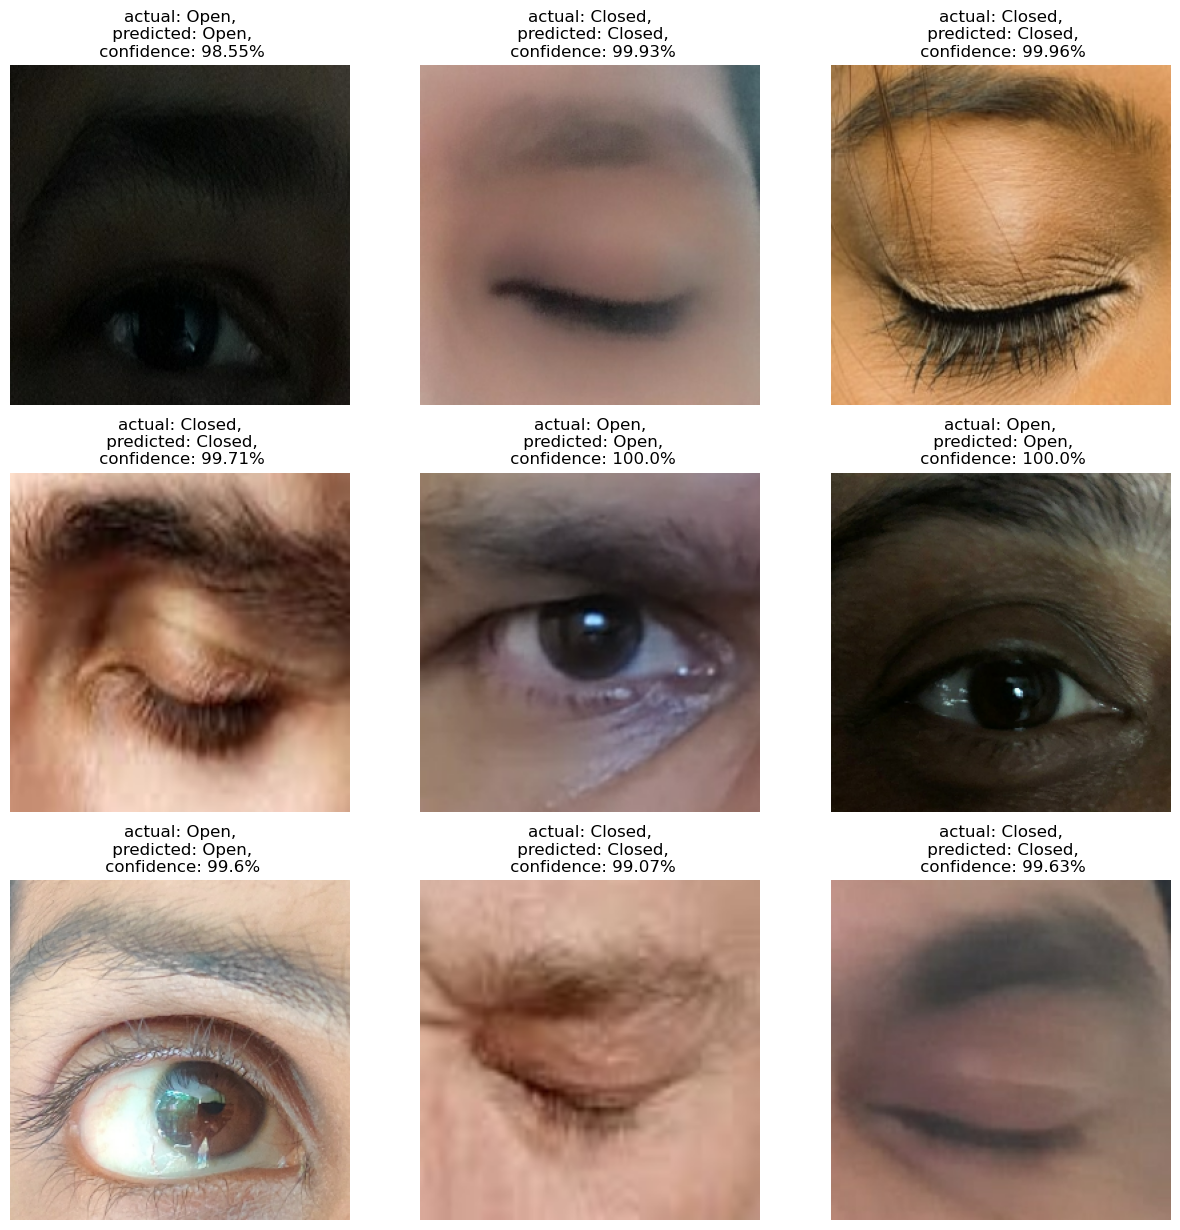

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual: {actual_class},\n predicted: {predicted_class},\n confidence: {confidence}%")
        plt.axis('off')

In [23]:
model.save('C:/Users/nazil/Downloads/models/new_model.h5')

C:\Users\nazil\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
